# Covid19
These are some visualizations from John Hopkin's repo [COVID-19](https://github.com/CSSEGISandData/COVID-19).

In [98]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import git

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,6)

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [99]:
# git.Repo.clone_from("https://github.com/CSSEGISandData/COVID-19", "COVID-19");
g = git.cmd.Git("COVID-19")
g.pull()

'Already up to date.'

# Deaths

In [100]:
df = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")

In [101]:
def csv_to_timeseries(df,field,value):
    """Convert one row of the raw dataframe to a TimeSeries.
    
    Arguments
    ---------
    field: str, name of the column to filter by (e.g. "Country/Region")
    country: str, value of the column to filter by (eg. "Italy")
    
    Returns
    -------
    Series object, indexed by date with death counts
    """
    
    d = df.groupby(field).get_group(value).agg(sum) # compute total over provinces
    d.drop(labels=["Province/State","Country/Region","Lat","Long"],inplace=True)
    d.index = pd.to_datetime(d.index)
    
    return d.astype('int32')

## Extract timeseries

Which countries have the most deaths until now?

In [102]:
df[df['3/12/20']>50]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
16,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,79,107,148,197,233,366,463,631,827,827
18,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,1,2,3,5,10,17,28,35,54,55
156,Hubei,China,30.9756,112.2707,17,17,24,40,52,76,...,2835,2871,2902,2931,2959,2986,3008,3024,3046,3056
157,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,77,92,107,124,145,194,237,291,354,429
158,NaN,"Korea, South",36.0000,128.0000,0,0,0,0,0,0,...,28,35,35,42,44,50,53,54,60,66


In [103]:
ita = csv_to_timeseries(df,"Country/Region","Italy")
ita = ita[ita>0]
ira = csv_to_timeseries(df,"Country/Region","Iran")
ira = ira[ira>0]
hub = csv_to_timeseries(df,"Province/State","Hubei")
hub = hub[hub>0]
kor = csv_to_timeseries(df,"Country/Region","Korea, South")
kor = kor[kor>0]
esp = csv_to_timeseries(df,"Country/Region","Spain")
esp = esp[esp>0]

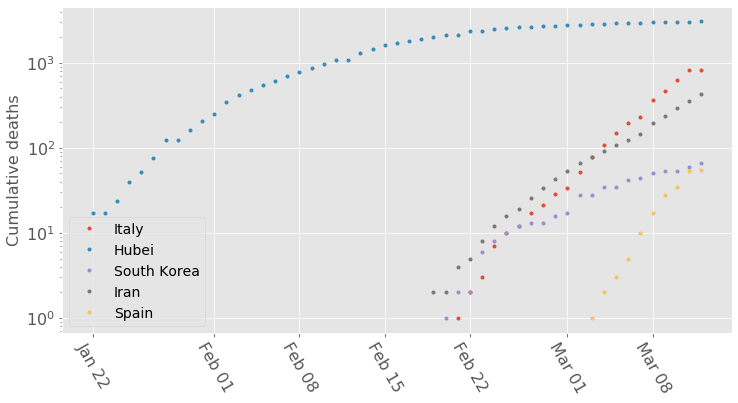

In [104]:
plt.plot(ita,'.',label="Italy")
plt.plot(hub,'.',label="Hubei")
plt.plot(kor,'.',label="South Korea")
plt.plot(ira,'.',label="Iran")
plt.plot(esp,'.',label="Spain")

plt.yscale('log')
# plt.xlim(left=np.datetime64('2020-02-16'))
plt.ylabel('Cumulative deaths')
plt.xticks(rotation=-60)
# ax.xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend();

## Logistic growth model
The number of deaths is well predicted by a simple logistic model.

In [106]:
# x must be a number, not a datetime
def logistic(x,a,b,x0): return a/(1+np.exp(-(x-x0)/b))

def fit_log(data,trange=None):
    
    offset_num = mdates.date2num(data.index[0])
    t = mdates.date2num(data.index) 

    p0 = [1e4,1,offset_num]
    err = np.sqrt(1+data)
    popt,pcov = curve_fit(logistic,t,data,p0=p0,sigma=err)

    print("Final estimated deceased: {}".format(int(popt[0])))
    print("Time constant: {:.2} days".format(popt[1]))
    inflection_date = mdates.num2date(popt[2])
    print("Inflection date: "+inflection_date.strftime("%F"))
    
    return popt

In [380]:
def gompertz(x,a,c,x0): return a*np.exp(-np.exp(-c*(x-x0)))

def fit_gom(data,trange=None):
    
    offset_num = mdates.date2num(data.index[0])
    t = mdates.date2num(data.index) 
    
    p0 = [1e3,.5,offset_num]
    err = np.sqrt(1+data)
    popt,pcov = curve_fit(gompertz,t,data,p0=p0,sigma=err)

    print("Final estimated deceased: {}".format(int(popt[0])))
#     print("Time constant: {:.2} days".format(popt[1]))
#     inflection_date = mdates.num2date(popt[2])
#     print("Inflection date: "+inflection_date.strftime("%F"))
    
    return popt

In [405]:
optitg = fit_gom(ita['2020-02-23':])

Final estimated deceased: 276435


### Italy

In [406]:
optitl = fit_log(ita['2020-02-23':])

Final estimated deceased: 1759
Time constant: 2.9 days
Inflection date: 2020-03-11


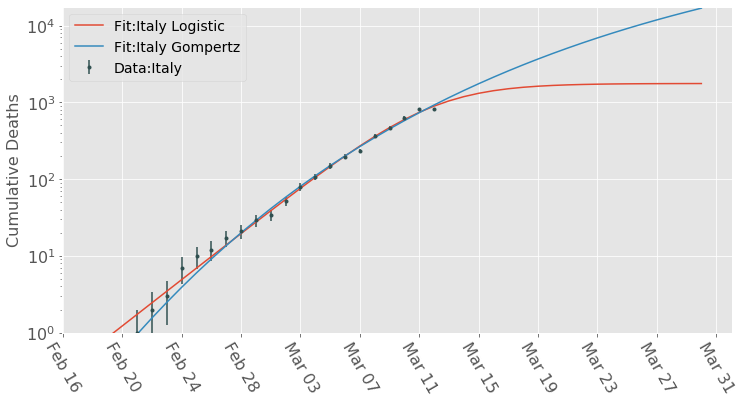

In [408]:
dita = pd.date_range('2020-02-18','2020-03-30')

plt.plot(dita,logistic(mdates.date2num(dita),*optitl),label="Fit:Italy Logistic")
plt.plot(dita,gompertz(mdates.date2num(dita),*optitg),label="Fit:Italy Gompertz")
plt.errorbar(ita.index,ita,fmt='.',yerr=np.sqrt(ita),label="Data:Italy", color="darkslategray")

plt.ylabel("Cumulative Deaths")
plt.legend()
plt.xticks(rotation=-60)
plt.ylim(bottom=1)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.yscale('log')

Let's look at the daily increase factor, defined as the logarithmic derivative:
$$
r = \frac{f'(t)}{f(t)}
$$
which is useful to distinguish between an exponential and a logistic growth: for an exponential it is constant (equal to the typical time), while for a logistic curve it's 
$$
\frac{1}{e^{(t-t_0)/\tau} + 1} \frac{1}{\tau}
$$
and it eventually approaches zero.

Of course, this data is discrete, so we have to use an approximation for the derivative.

In [409]:
def r_logistic(t,tau,t0):
    return 1/(tau*(1+np.exp((t-t0)/tau)))

def logder(data):
    return ((data.diff(periods=1) - data.diff(periods=-1))/2)[1:-1]/data[1:-1]

def r_gomper(t,tau,t0):
    return np.exp(-(t-t0)/tau)/tau

In [410]:
rita = logder(ita)

In [411]:
tau = optitl[1]
offset = optitl[2]
ritam = r_logistic(mdates.date2num(dita),tau,offset)

tau = 1/optitg[1]
offset = optitg[2]
ritag = r_gomper(mdates.date2num(dita),tau,offset)

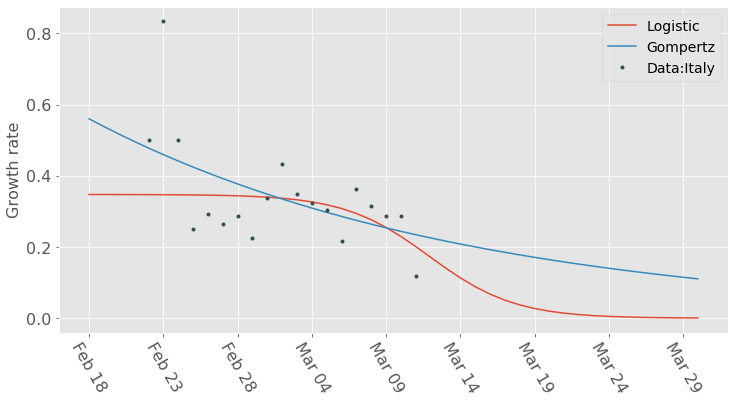

In [412]:
plt.plot(dita,ritam,label="Logistic")
plt.plot(dita,ritag,label="Gompertz")
plt.plot(rita,'.',label="Data:Italy",color="darkslategray")
plt.legend()

plt.ylabel("Growth rate")
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

it looks like the disease is still in its exponential regime, as of 2020-03-10.

### Hubei

In [418]:
phubtot = fit_log(hub['2020-01-25':])

Final estimated deceased: 2967
Time constant: 5.6 days
Inflection date: 2020-02-14


In [419]:
phubg = fit_gom(hub['2020-01-25':])

Final estimated deceased: 3433


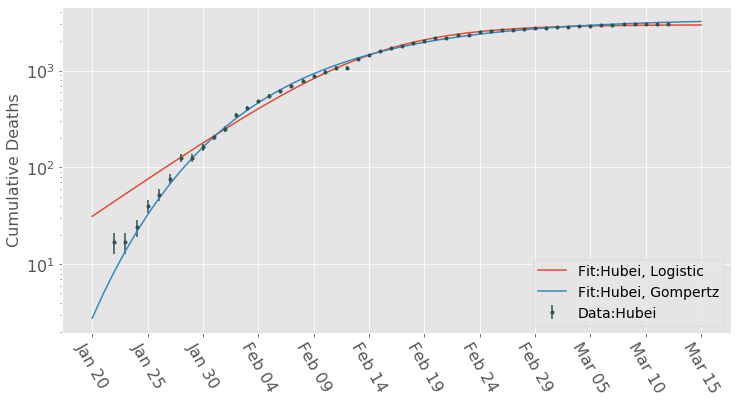

In [420]:
dhub = pd.date_range('2020-01-20','2020-03-15')

plt.plot(dhub,logistic(mdates.date2num(dhub),*phubtot),label="Fit:Hubei, Logistic")
plt.plot(dhub,gompertz(mdates.date2num(dhub),*phubg),label="Fit:Hubei, Gompertz")
# plt.plot(dhub,logistic(mdates.date2num(dhub),*phubearly),label="Fit:Hubei,early")
plt.errorbar(hub.index,hub,np.sqrt(hub),fmt='.',label="Data:Hubei",color='darkslategray')

plt.ylabel("Cumulative Deaths")
plt.legend(loc='lower right')
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.yscale('log')

In [371]:
rhub = logder(hub)

In [413]:
tau = phubtot[1]
offset = phubtot[2]
rhubm = r_logistic(mdates.date2num(dhub),tau,offset)

tau = 1/phubg[1]
offset = phubg[2]
rhubg = r_gomper(mdates.date2num(dhub),tau,offset)

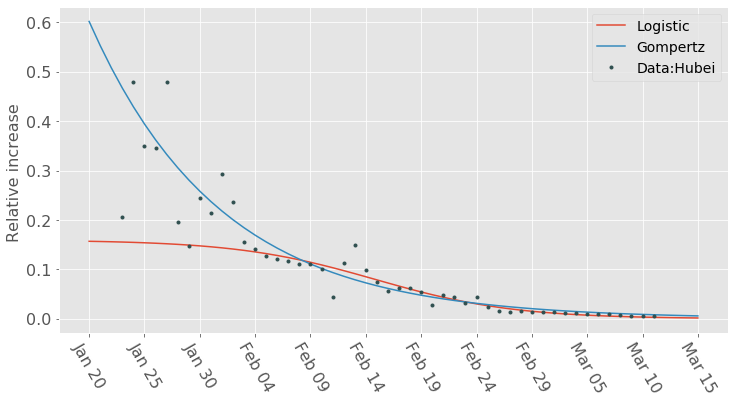

In [415]:
plt.plot(dhub,rhubm,label="Logistic")
plt.plot(dhub,rhubg,label="Gompertz")
plt.plot(rhub,'.',label="Data:Hubei",color="darkslategray")
plt.legend()

plt.ylabel("Relative increase ")
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Iran

In [129]:
pira = fit_log(ira['2020-02-23':])

Final estimated deceased: 6689
Time constant: 4.9 days
Inflection date: 2020-03-25


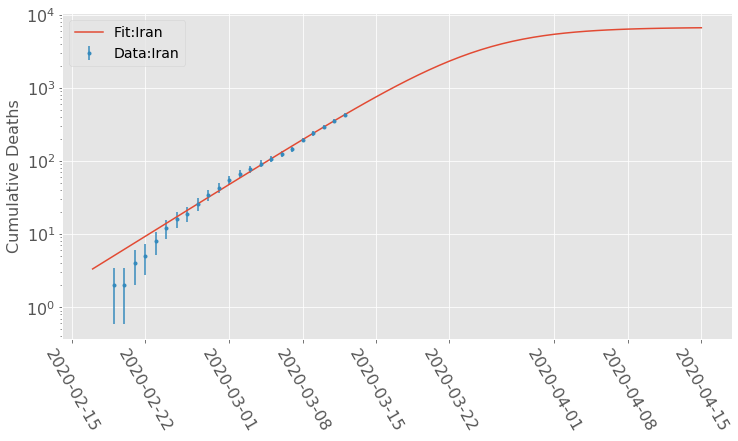

In [130]:
dira = pd.date_range('2020-02-17','2020-04-15')

plt.plot(dira,logistic(mdates.date2num(dira),*pira),label="Fit:Iran")
plt.errorbar(ira.index,ira,np.sqrt(ira),fmt='.',label="Data:Iran")

plt.ylabel("Cumulative Deaths"); plt.legend()
plt.xticks(rotation=-60)
plt.yscale('log')

In [28]:
rira = logder(ira)

In [37]:
tau = pira[1]
offset = pira[2]
riram = r_logistic(mdates.date2num(dira),tau,offset)

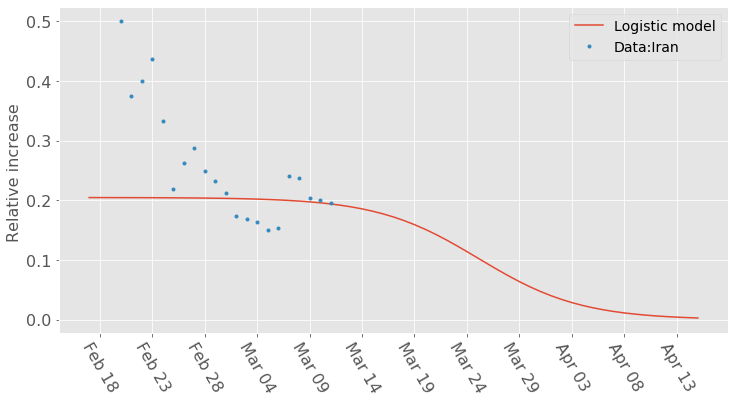

In [39]:
plt.plot(dira,riram,label="Logistic model")
plt.plot(rira,'.',label="Data:Iran")
plt.legend()

plt.ylabel("Relative increase ")
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

## Comparisons

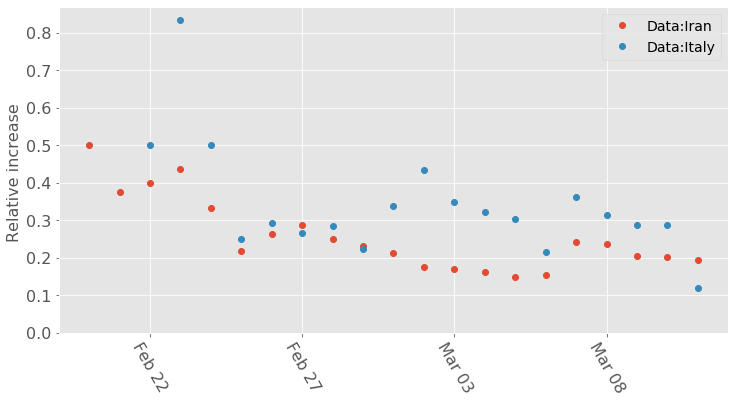

In [40]:
# plt.plot(dhub + 36*dhub.freq,rhubm,label="Logistic model")
# plt.plot(rhub.tshift(36),'o',label="Data:Hubei")

plt.plot(rira.tshift(0),'o',label="Data:Iran")

# plt.plot(dita,ritam,label="Logistic model")
plt.plot(rita,'o',label="Data:Italy")

plt.legend()

plt.ylim(bottom=0)

plt.ylabel("Relative increase ")
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

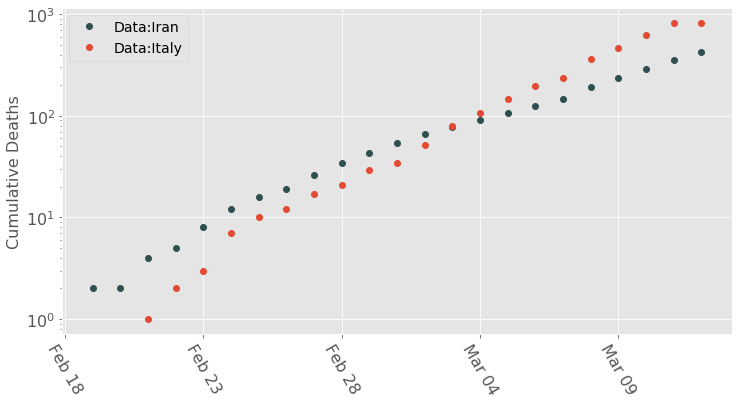

In [41]:
# plt.plot(dhub + dhub.freq*36,logistic(mdates.date2num(dhub),*phubtot),label="Fit:Hubei,total")
# plt.plot(dhub,logistic(mdates.date2num(dhub),*phubearly),label="Fit:Hubei,early")
# plt.plot(hub.tshift(36),'o',label="Data:Hubei",color='darkslategray')
plt.plot(ira.tshift(0),'o',label="Data:Iran",color='darkslategray')

# plt.plot(dita,logistic(mdates.date2num(dita),*optit),label="Fit:Italy")
plt.plot(ita.tshift(0),'o',label="Data:Italy")

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.ylabel("Cumulative Deaths")
plt.legend()
plt.xticks(rotation=-60)
plt.yscale('log')

# Confirmed cases

In [44]:
df = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

In [45]:
def csv_to_timeseries(df,field,value):
    """Convert one row of the raw dataframe to a TimeSeries.
    
    Arguments
    ---------
    field: str, name of the column to filter by (e.g. "Country/Region")
    country: str, value of the column to filter by (eg. "Italy")
    
    Returns
    -------
    Series object, indexed by date with death counts
    """
    
    d = df.groupby(field).get_group(value).agg(sum) # compute total over provinces
    d.drop(labels=["Province/State","Country/Region","Lat","Long"],inplace=True)
    d.index = pd.to_datetime(d.index)
    
    return d.astype('int32')

## Extract timeseries

Which countries have the most deaths until now?

In [48]:
df[df['3/12/20']>1000]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
11,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,196,262,482,670,799,1040,1176,1457,1908,2078
16,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462
18,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,165,222,259,400,500,673,1073,1695,2277,2277
156,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67217,67332,67466,67592,67666,67707,67743,67760,67773,67781
157,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,2336,2922,3513,4747,5823,6566,7161,8042,9000,10075
158,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,5186,5621,6088,6593,7041,7314,7478,7513,7755,7869
159,France,France,46.2276,2.2137,0,0,2,3,3,3,...,204,285,377,653,949,1126,1209,1784,2281,2281
160,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,1350,1350,1351,1352,1352,1352,1352,1353,1356,1356
161,Henan,China,33.8820,113.6140,5,5,9,32,83,128,...,1272,1272,1272,1272,1272,1272,1272,1272,1273,1273
162,Zhejiang,China,29.1832,120.0934,10,27,43,62,104,128,...,1213,1213,1215,1215,1215,1215,1215,1215,1215,1215


In [49]:
ita = csv_to_timeseries(df,"Country/Region","Italy")
ita = ita[ita>0]
ira = csv_to_timeseries(df,"Country/Region","Iran")
ira = ira[ira>0]
hub = csv_to_timeseries(df,"Province/State","Hubei")
hub = hub[hub>0]
kor = csv_to_timeseries(df,"Country/Region","Korea, South")
kor = kor[kor>0]
esp = csv_to_timeseries(df,"Country/Region","Spain")
esp = esp[esp>0]

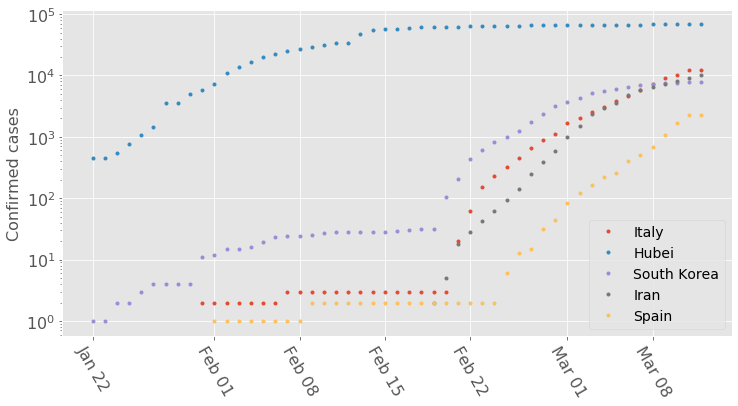

In [72]:
plt.plot(ita,'.',label="Italy")
plt.plot(hub,'.',label="Hubei")
plt.plot(kor,'.',label="South Korea")
plt.plot(ira,'.',label="Iran")
plt.plot(esp,'.',label="Spain")

plt.yscale('log')
# plt.xlim(left=np.datetime64('2020-02-16'))
plt.ylabel('Confirmed cases')
plt.xticks(rotation=-60)
# ax.xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend();

## Logistic growth model
The number of deaths is well predicted by a simple logistic model.

In [51]:
# x must be a number, not a datetime
def logistic(x,a,b,x0): return a/(1+np.exp(-(x-x0)/b))

In [73]:
def fit_log(data,trange=None):
    
    offset_num = mdates.date2num(data.index[0])
    t = mdates.date2num(data.index) 

    p0 = [1e4,1,offset_num]
    err = np.sqrt(1+data)
    popt,pcov = curve_fit(logistic,t,data,p0=p0,sigma=err)

    print("Final estimated cases: {}".format(int(popt[0])))
    print("Time constant: {:.2} days".format(popt[1]))
    inflection_date = mdates.num2date(popt[2])
    print("Inflection date: "+inflection_date.strftime("%F"))
    
    return popt

### Italy

In [74]:
optit = fit_log(ita['2020-02-24':])

Final estimated cases: 20174
Time constant: 3.5 days
Inflection date: 2020-03-09


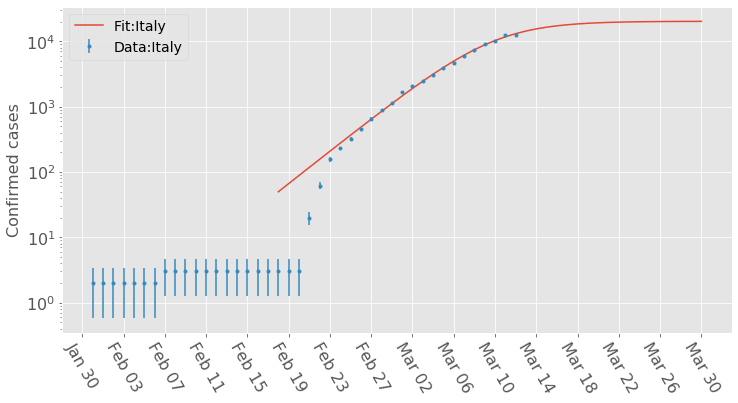

In [76]:
dita = pd.date_range('2020-02-18','2020-03-30')

plt.plot(dita,logistic(mdates.date2num(dita),*optit),label="Fit:Italy")
plt.errorbar(ita.index,ita,fmt='.',yerr=np.sqrt(ita),label="Data:Italy")

plt.ylabel("Confirmed cases")
plt.legend()
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.yscale('log')

Let's look at the daily increase factor, defined as the logarithmic derivative:
$$
r = \frac{f'(t)}{f(t)}
$$
which is useful to distinguish between an exponential and a logistic growth: for an exponential it is constant (equal to the typical time), while for a logistic curve it's 
$$
\frac{1}{e^{(t-t_0)/\tau} + 1} \frac{1}{\tau}
$$
and it eventually approaches zero.

Of course, this data is discrete, so we have to use an approximation for the derivative.

In [55]:
def r_logistic(t,tau,t0):
    return 1/(tau*(1+np.exp((t-t0)/tau)))

def logder(data):
    return ((data.diff(periods=1) - data.diff(periods=-1))/2)[1:-1]/data[1:-1]

In [56]:
rita = logder(ita)

In [57]:
tau = optit[1]
offset = optit[2]
ritam = r_logistic(mdates.date2num(dita),tau,offset)

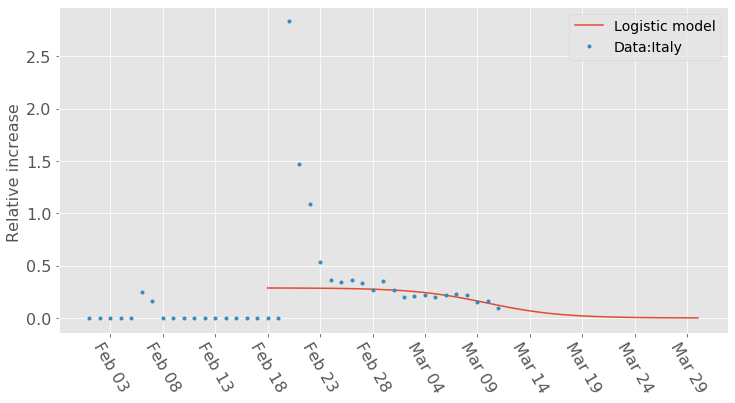

In [58]:
plt.plot(dita,ritam,label="Logistic model")
plt.plot(rita,'.',label="Data:Italy")
plt.legend()

plt.ylabel("Relative increase ")
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

it looks like the disease is still in its exponential regime, as of 2020-03-10.

### Hubei

In [59]:
phubtot = fit_log(hub['2020-02-01':])

Final estimated deceased: 68094
Time constant: 4.6 days
Inflection date: 2020-02-09


In [60]:
phubearly = fit_log(hub['2020-01-22':'2020-02-08'])

Final estimated deceased: 34291
Time constant: 2.8 days
Inflection date: 2020-02-04


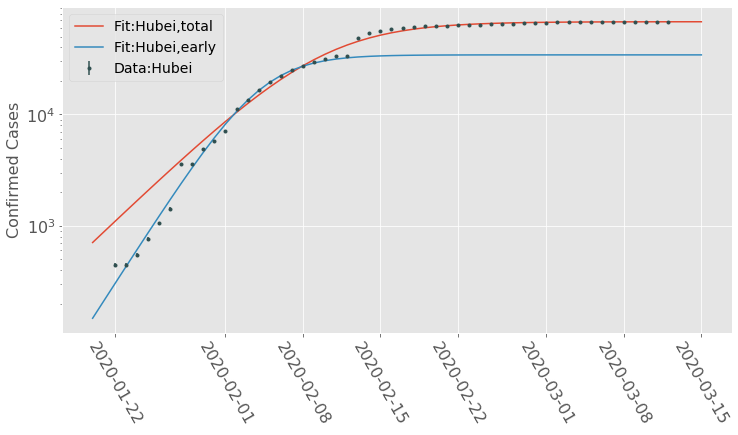

In [78]:
dhub = pd.date_range('2020-01-20','2020-03-15')

plt.plot(dhub,logistic(mdates.date2num(dhub),*phubtot),label="Fit:Hubei,total")
plt.plot(dhub,logistic(mdates.date2num(dhub),*phubearly),label="Fit:Hubei,early")
plt.errorbar(hub.index,hub,np.sqrt(hub),fmt='.',label="Data:Hubei",color='darkslategray')

plt.ylabel("Confirmed Cases")
plt.legend()
plt.xticks(rotation=-60)
plt.yscale('log')

In [79]:
rhub = logder(hub)

In [80]:
tau = phubtot[1]
offset = phubtot[2]
rhubm = r_logistic(mdates.date2num(dhub),tau,offset)

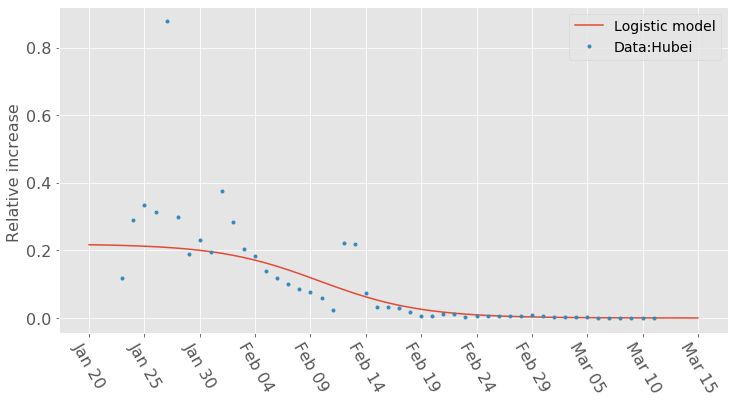

In [81]:
plt.plot(dhub,rhubm,label="Logistic model")
plt.plot(rhub,'.',label="Data:Hubei")
plt.legend()

plt.ylabel("Relative increase ")
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Iran

In [82]:
pira = fit_log(ira['2020-02-23':])

Final estimated cases: 10031
Time constant: 2.3 days
Inflection date: 2020-03-06


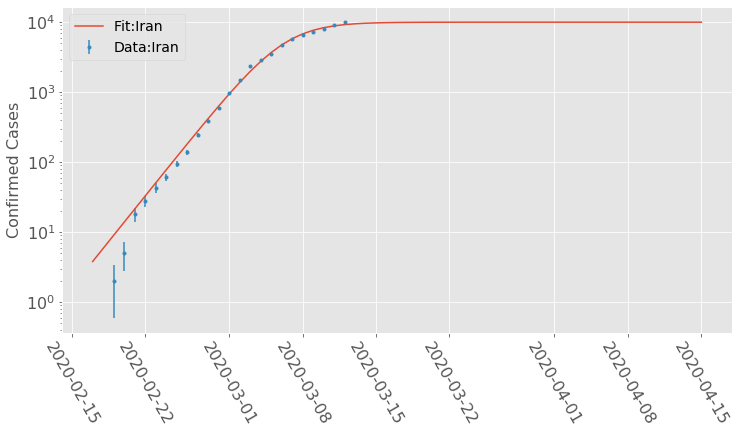

In [85]:
dira = pd.date_range('2020-02-17','2020-04-15')

plt.plot(dira,logistic(mdates.date2num(dira),*pira),label="Fit:Iran")
plt.errorbar(ira.index,ira,np.sqrt(ira),fmt='.',label="Data:Iran")

plt.ylabel("Confirmed Cases"); plt.legend()
plt.xticks(rotation=-60)
plt.yscale('log')

In [86]:
rira = logder(ira)

In [87]:
tau = pira[1]
offset = pira[2]
riram = r_logistic(mdates.date2num(dira),tau,offset)

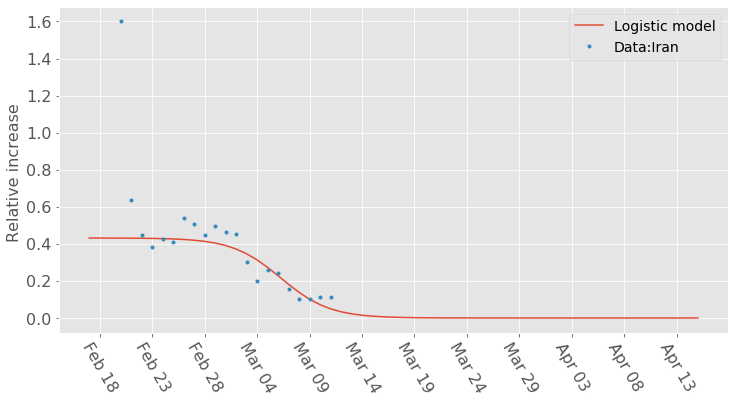

In [88]:
plt.plot(dira,riram,label="Logistic model")
plt.plot(rira,'.',label="Data:Iran")
plt.legend()

plt.ylabel("Relative increase ")
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

## Comparisons

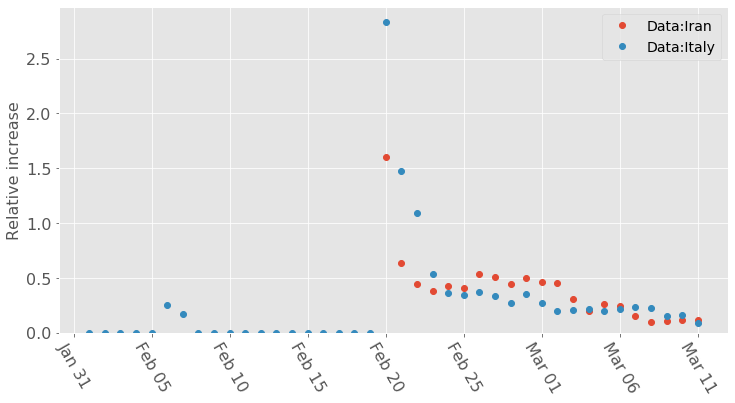

In [90]:
# plt.plot(dhub + 36*dhub.freq,rhubm,label="Logistic model")
# plt.plot(rhub.tshift(36),'o',label="Data:Hubei")

plt.plot(rira.tshift(0),'o',label="Data:Iran")

# plt.plot(dita,ritam,label="Logistic model")
plt.plot(rita,'o',label="Data:Italy")

plt.legend()

plt.ylim(bottom=0)

plt.ylabel("Relative increase")
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

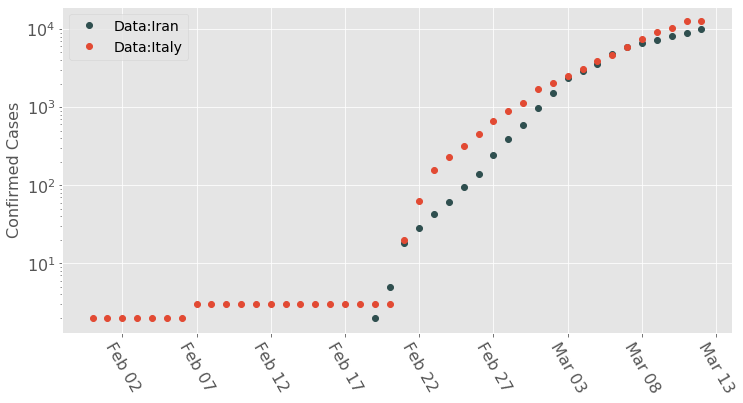

In [91]:
# plt.plot(dhub + dhub.freq*36,logistic(mdates.date2num(dhub),*phubtot),label="Fit:Hubei,total")
# plt.plot(dhub,logistic(mdates.date2num(dhub),*phubearly),label="Fit:Hubei,early")
# plt.plot(hub.tshift(36),'o',label="Data:Hubei",color='darkslategray')
plt.plot(ira.tshift(0),'o',label="Data:Iran",color='darkslategray')

# plt.plot(dita,logistic(mdates.date2num(dita),*optit),label="Fit:Italy")
plt.plot(ita.tshift(0),'o',label="Data:Italy")

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.ylabel("Confirmed Cases")
plt.legend()
plt.xticks(rotation=-60)
plt.yscale('log')